In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import warnings
import os
from scipy.interpolate import griddata



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import meshio
import re

In [2]:
import cfdnetplus

In [3]:
path_to_main= 'airfoil2d/'
folders=['airFoil_1000', 'airFoil_30', 'airFoil_300','airFoil_600', 'airFoil_3000', 'airFoil_2000']
#folders=['airFoil_1000']
fields= ['U','p','k','omega', 'nut']
xlim =[-50,50]
ylim = [-30 , 30]
xres=256
yres=66
zcut=0.05
modelid='model_newsep'

In [86]:
cfdnetplus.VTK2np(path_to_main,folders, fields,'xy' ,xres,yres,xlim,ylim,zcut)

processing data in airfoil2d/airFoil_1000/VTK/
(339, 66, 256, 7)
339
[266]
data written toairfoil2d/airFoil_1000/VTK/df
processing data in airfoil2d/airFoil_30/VTK/
(600, 66, 256, 7)
600
[555]
data written toairfoil2d/airFoil_30/VTK/df
processing data in airfoil2d/airFoil_300/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_300/VTK/df
processing data in airfoil2d/airFoil_600/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_600/VTK/df
processing data in airfoil2d/airFoil_3000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_3000/VTK/df
processing data in airfoil2d/airFoil_2000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_2000/VTK/df


['airfoil2d/airFoil_1000/VTK/',
 'airfoil2d/airFoil_30/VTK/',
 'airfoil2d/airFoil_300/VTK/',
 'airfoil2d/airFoil_600/VTK/',
 'airfoil2d/airFoil_3000/VTK/',
 'airfoil2d/airFoil_2000/VTK/']

In [4]:
if 'U' in fields:
    l=len(fields)+2
else:
    l=len(fields)

df = np.empty((0,66,256,l))
df_label = np.empty((0,66,256,l))
path_to_folders=[]
for i in folders:
    path_to_folders.append(path_to_main+i+'/VTK/')
    df_t=np.load(path_to_main+i+'/VTK/df.npy')
    df_tlabel=np.load(path_to_main+i+'/VTK/df_label.npy')
    norm=np.amax(abs(df_t), axis=(0,1,2))
    df=np.concatenate((df,df_t*(1/norm)))
    df_label=np.concatenate((df_label,df_tlabel*(1/norm)))
print(df_label.shape)

(2295, 66, 256, 7)


In [5]:

Ux_max=np.max(abs(df[:,:,:,[0]]))
Uy_max=np.max(abs(df[:,:,:,[1]]))
p_max=np.max(abs(df[:,:,:,[3]]))
k_max=np.max(abs(df[:,:,:,[4]]))
omega_max=np.max(abs(df[:,:,:,[5]]))
nut_max=np.max(abs(df[:,:,:,[6]]))
normal=[Ux_max,Uy_max,0,p_max,k_max,omega_max,nut_max]
print(normal)

[1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0]


In [5]:
n=0
df_label=df_label[:,:,:,n]
df=df[:,:,:,n]


In [6]:
[a,b,c]=df_label.shape
df=np.reshape(df,[a,b,c,1])
df_label=np.reshape(df_label,[a,b,c,1])
print(df.shape)

(2295, 66, 256, 1)


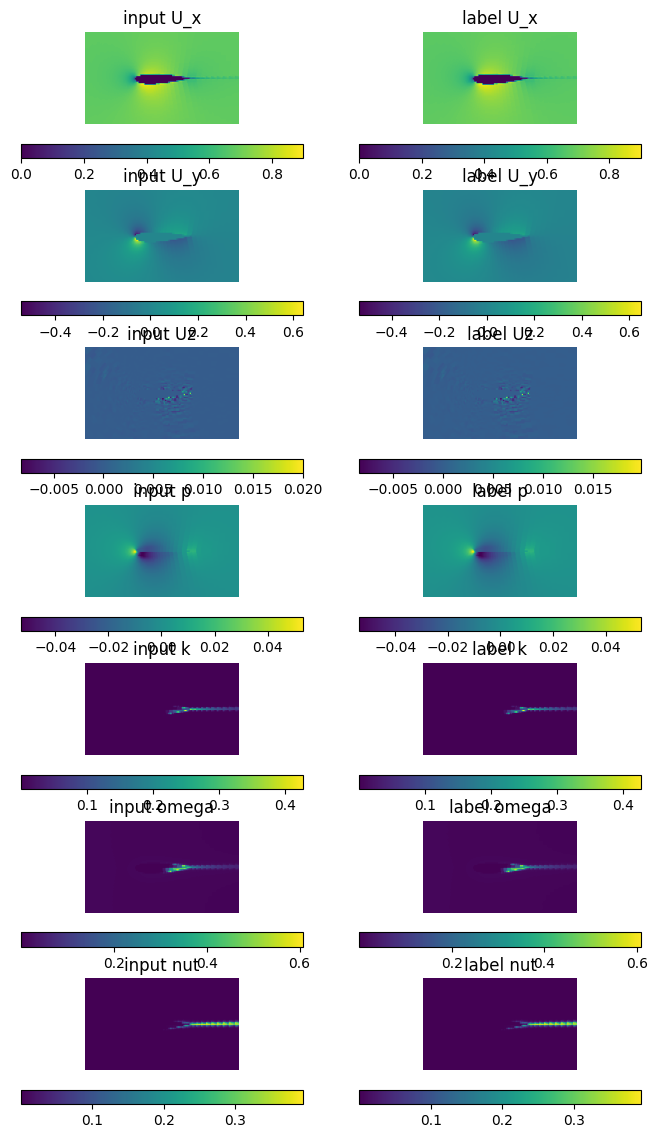

In [48]:

n=100
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=df.shape
titles= ['U_x','U_y','Uz','p','k','omega','nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(df[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('input ' +titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(df_label[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label '+titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    #print(i)

plt.show()

In [265]:
#normalise U Vektors


Ux_max=np.max(abs(df[:,:,:,[0]]))
Uy_max=np.max(abs(df[:,:,:,[1]]))
p_max=np.max(abs(df[:,:,:,[3]]))
k_max=np.max(abs(df[:,:,:,[4]]))
omega_max=np.max(abs(df[:,:,:,[5]]))
nut_max=np.max(abs(df[:,:,:,[6]]))

model_path='cfdnetplus_models/'+modelid+'/'
normal=np.array([Ux_max,Uy_max,0,p_max,k_max,omega_max,nut_max]).reshape(1,1,1,l)
print(normal)

if os.path.isdir(model_path)== False:
    os.mkdir(model_path)
np.save(model_path+'normal',normal)
print(model_path+'')

[[[[4.41323047e+03 2.61715942e+03 0.00000000e+00 7.33556320e+07
    2.83279031e+05 1.93653164e+04 4.86423264e+01]]]]
cfdnetplus_models/model_sep/


In [9]:
U_max=np.max(abs(df[:,:,:,0]))
#normal=[U_max].reshape(1,1,1,1)
normal=U_max

In [131]:
contents=''
for field in fields:
    contents=contents+field+ '\n'
print(contents)
with open(model_path+'fields',"w") as f:
            f.writelines(contents)
dims=np.array([xres,yres,xlim[0],xlim[1],ylim[0],ylim[1],zcut])
np.save(model_path+'dims',dims)

U
p
k
omega
nut



In [49]:
train_data, test_data, label_train, label_test = train_test_split (df, df_label, test_size = 0.15)

20


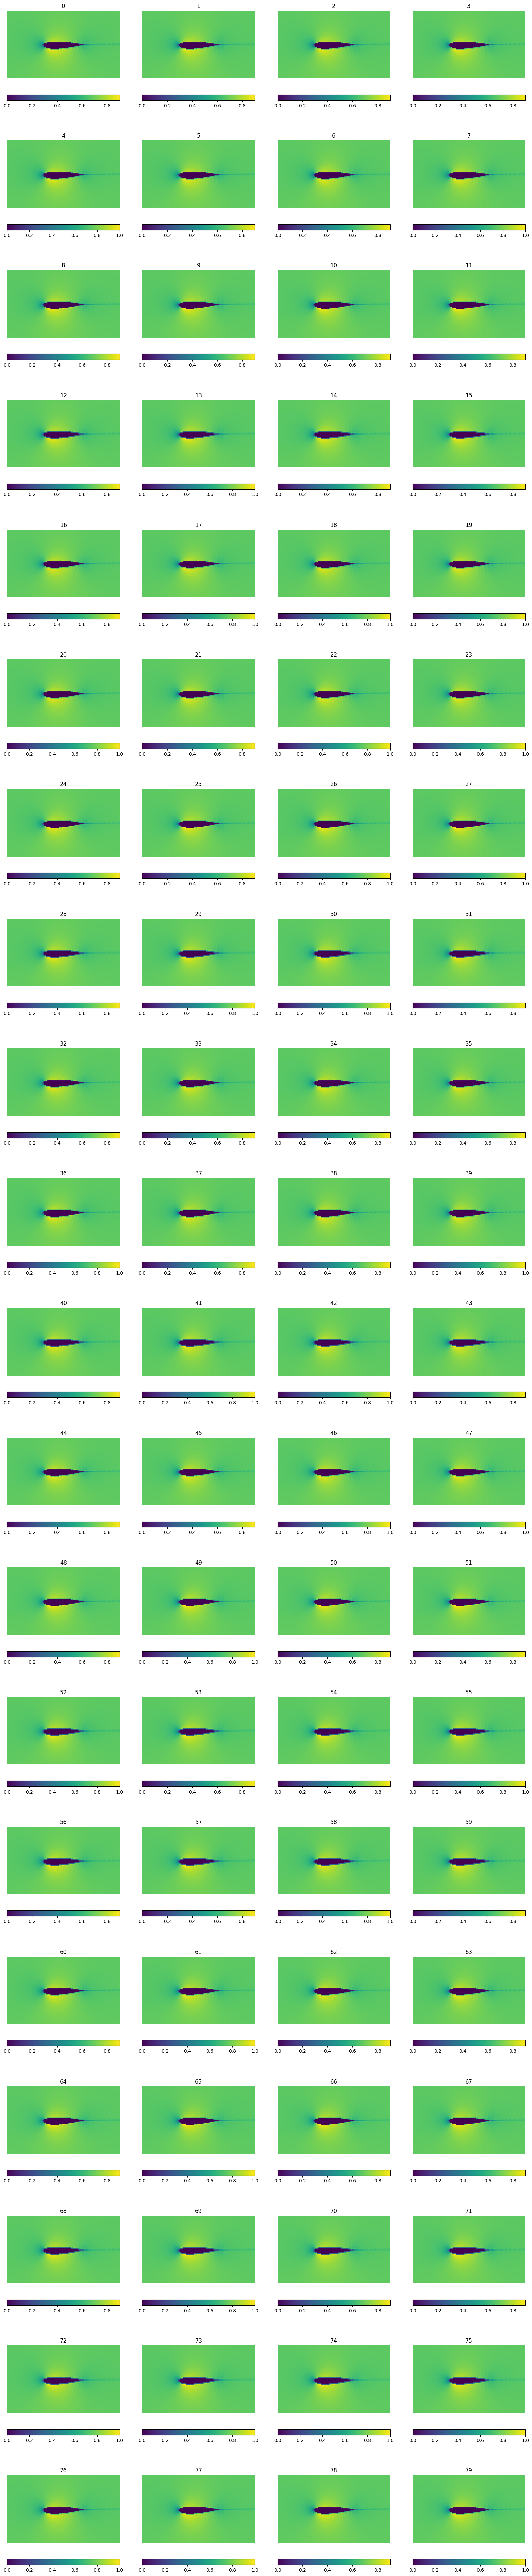

In [50]:
[a,b,c,d]=label_train.shape
fig = plt.figure(figsize=(20, 100))
columns = 4
rows = 20
print(rows)

for i in range( columns * rows):
    img = label_train[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i)
    plt.axis('off')
    plt.colorbar(location='bottom')

plt.show()

In [51]:
[a,b,c,d]=df.shape

In [52]:
# Valid for input with four layers
model = models.Sequential()
model.add(layers.Conv2D(16,( 4,12), (2, 8), activation='tanh',padding="same", input_shape=(66,256, d)))
model.add(layers.Conv2D(64,(6), (3, 4), activation='tanh',padding="same",))
model.add(layers.Conv2D(256,(16,12), (11, 8), activation='tanh',padding="same",))
model.add(layers.Conv2DTranspose(32,(14,10),(11,8), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(16,(6,8),(3,4), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(d,(4,16),(2,8), activation='linear', padding="same"))

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 32, 16)        5392      
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 8, 64)         36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 256)         3145984   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 11, 8, 32)        1146912   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 33, 32, 16)       24592     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 66, 256, 7)       7

In [54]:
model.compile(optimizer='adam',
              loss='mse')

In [55]:
folders=os.listdir('training/')
print(folders)
sub='training_'
folders = [x for x in folders if re.search(sub, x)]
#print(len(folders))
if len(folders)==0:
    filefolder=sub+'0'
else:
    id=[]
    for txt in folders:
        t=txt.split('_')
        id.append(int(t[len(t)-1]))
    index_max=np.argmax(id)
    filefolder= sub+str(id[index_max]+1)
print(filefolder)

['training_0', 'training_1', 'training_10', 'training_11', 'training_12', 'training_13', 'training_14', 'training_15', 'training_16', 'training_17', 'training_2', 'training_3', 'training_4', 'training_5', 'training_6', 'training_7', 'training_8', 'training_9']
training_18


In [56]:
filepath ='training/'+ filefolder+'/'+'vae_best_model_relu.epoch{epoch:02d}-loss{loss:.5f}.w'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [57]:
history = model.fit(train_data, label_train, epochs=100, 
                    validation_data=(test_data, label_test),
                    batch_size=32,
                   callbacks=callbacks)

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 0.0174
Epoch 1: loss improved from inf to 0.01735, saving model to training/training_18\vae_best_model_relu.epoch01-loss0.01735.w
61/61 [==============================] - 17s 271ms/step - loss: 0.0174 - val_loss: 0.0029
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 0.0024
Epoch 2: loss improved from 0.01735 to 0.00240, saving model to training/training_18\vae_best_model_relu.epoch02-loss0.00240.w
61/61 [==============================] - 16s 261ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 0.0016
Epoch 3: loss improved from 0.00240 to 0.00161, saving model to training/training_18\vae_best_model_relu.epoch03-loss0.00161.w
61/61 [==============================] - 16s 258ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/100
61/61 [==============================] - ETA: 0s - loss: 0.0011
Epoch 4: loss improved from 0.00161 to 0.00111, s

61/61 [==============================] - 16s 258ms/step - loss: 2.4938e-04 - val_loss: 2.2654e-04
Epoch 64/100
61/61 [==============================] - ETA: 0s - loss: 2.6209e-04
Epoch 64: loss did not improve from 0.00025
61/61 [==============================] - 16s 263ms/step - loss: 2.6209e-04 - val_loss: 2.2148e-04
Epoch 65/100
61/61 [==============================] - ETA: 0s - loss: 2.5130e-04
Epoch 65: loss did not improve from 0.00025
61/61 [==============================] - 16s 259ms/step - loss: 2.5130e-04 - val_loss: 2.3789e-04
Epoch 66/100
61/61 [==============================] - ETA: 0s - loss: 2.5291e-04
Epoch 66: loss did not improve from 0.00025
61/61 [==============================] - 16s 255ms/step - loss: 2.5291e-04 - val_loss: 2.2898e-04
Epoch 67/100
61/61 [==============================] - ETA: 0s - loss: 2.5776e-04
Epoch 67: loss did not improve from 0.00025
61/61 [==============================] - 15s 247ms/step - loss: 2.5776e-04 - val_loss: 2.5255e-04
Epoch 68/1

61/61 [==============================] - 16s 259ms/step - loss: 2.4037e-04 - val_loss: 2.1592e-04
Epoch 99/100
61/61 [==============================] - ETA: 0s - loss: 2.5029e-04
Epoch 99: loss did not improve from 0.00024
61/61 [==============================] - 15s 253ms/step - loss: 2.5029e-04 - val_loss: 2.1895e-04
Epoch 100/100
61/61 [==============================] - ETA: 0s - loss: 2.4796e-04
Epoch 100: loss did not improve from 0.00024
61/61 [==============================] - 16s 255ms/step - loss: 2.4796e-04 - val_loss: 2.2417e-04


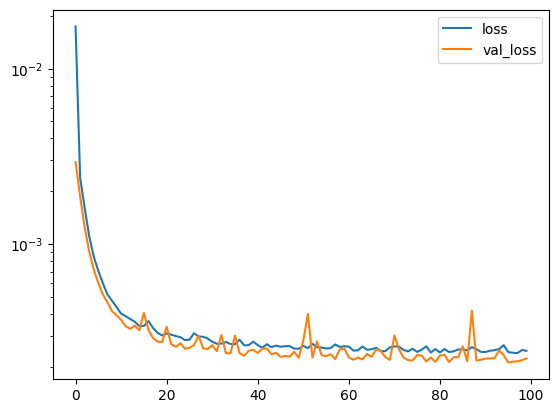

In [58]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
#plt.xlabel('Epoch')
#plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.yscale('log')
plt.legend(loc='upper right')

Finding the last epoch in the training folder

In [59]:
#filefolder= 'training_6'

folders=os.listdir('training/'+filefolder)
#folders=os.listdir('training/'+'training_0/')

sub='index'
folders = [x for x in folders if re.search(sub, x)]

ts=[]
for folder in folders:
    a=re.search('\d{2,3}',folder)
    ts.append(int(a.group(0)))
    #print(a.group(0))
index_max=np.max(ts)
print(index_max)
latest = [x for x in folders if re.search(str(index_max), x)]

latest=latest[0].split('.index')
print(latest[0])

98
vae_best_model_relu.epoch98-loss0.00024.w


In [60]:
weights_path='training/'+filefolder+'/'+latest[0]

#weights_path='training/'+'training_0'+'/'+latest[0]

print(weights_path)
model.load_weights(weights_path)

training/training_18/vae_best_model_relu.epoch98-loss0.00024.w


In [61]:
test=model.predict(test_data)

11/11 [==============================] - 1s 53ms/step


In [62]:
print(label_test.shape[0])
n=0
print('max:' , np.max(test[:,:,:,n]))
print('min:' , np.min(test[:,:,:,n]))
#label_test=label_test.reshape((36,66,256,4))
#plt.imshow(np.clip(label_test[1,:,:,3],0,1))

345
max: 0.95177513
min: -0.03914593


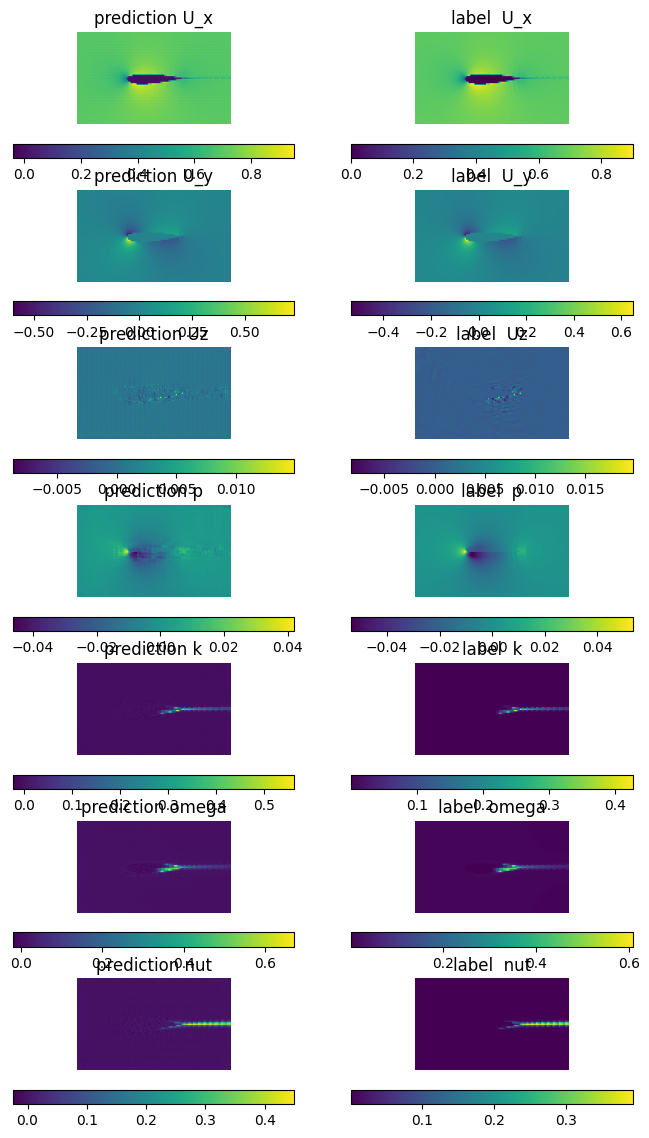

In [64]:
n=40
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=test.shape
#titles= ['Ux','Uy','Uz','p']
titles= ['U_x','U_y','Uz','p','k','omega','nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('prediction ' +titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(label_test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label  '+titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    #print(i)

plt.show()

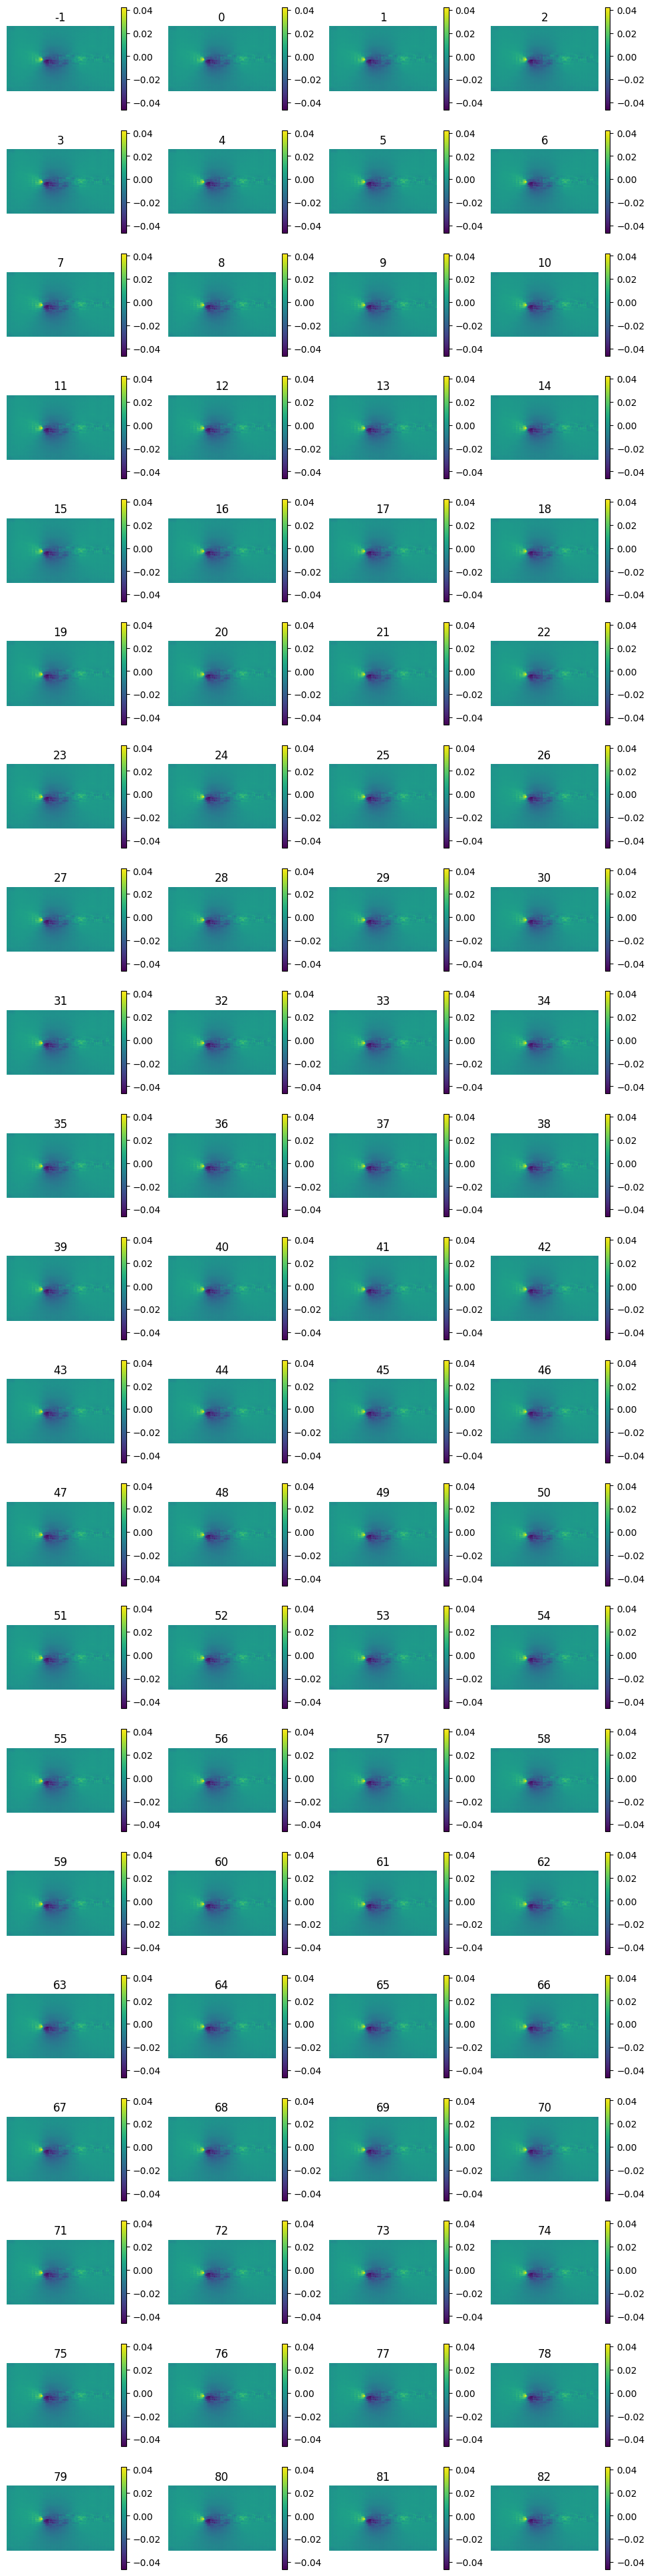

In [66]:
[a,b,c,d]=test.shape
fig = plt.figure(figsize=(12, 50))
columns = 4
rows = 21

for i in range( columns * rows):
    img = test[(i-1),:,:,3]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i-1)
    plt.axis('off')
    plt.colorbar()
plt.show()

In [149]:
mse=[]
ssim1=[]
for i in range(label_test.shape[0]):
    mse.append(mean_squared_error(test[i,:,:,0],label_test[i,:,:,0]))
    ssim1.append(ssim(test[i,:,:,0],label_test[i,:,:,0]))
print('max mse:'+ str(max(mse)))
print(ssim1[n])
print(mse[n])
mse=np.mean(mse)
ssim2=np.mean(ssim1[:])
print('average ssim: '+str(ssim2))
print('average mse: '+str(mse))

C:\Users\hansi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


max mse:2.7152526887379602e-05
0.999943384540081
1.0341332323513827e-07
average ssim: 0.9998922086021752
average mse: 2.634276224574286e-07


In [113]:
print(test.shape)

(345, 66, 256, 2)


In [67]:
#os.mkdir('cfdnetplus_models')
model.save('cfdnetplus_models/model_newnorm')

INFO:tensorflow:Assets written to: cfdnetplus_models/model_newnorm\assets


INFO:tensorflow:Assets written to: cfdnetplus_models/model_newnorm\assets
